In [9]:
import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [19]:
import pandas as pd

from src.preprocessing import preprocess_data
from src.config import RAW_DATA_PATH

df = preprocess_data(RAW_DATA_PATH)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,service_count
0,7590-VHVEG,Female,No,Yes,No,1,0,0,1,0,...,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 Months,2
1,5575-GNVDE,Male,No,No,No,34,1,0,1,1,...,0,0,One year,No,Mailed check,56.95,1889.50,No,12-36 Months,4
2,3668-QPYBK,Male,No,No,No,2,1,0,1,1,...,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 Months,4
3,7795-CFOCW,Male,No,No,No,45,0,0,1,1,...,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,No,36-60 Months,4
4,9237-HQITU,Female,No,No,No,2,1,0,1,0,...,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12 Months,2


In [11]:
# Selecting features for modeling
features = ["tenure", "MonthlyCharges", "TotalCharges", "service_count"]
X = df[features]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

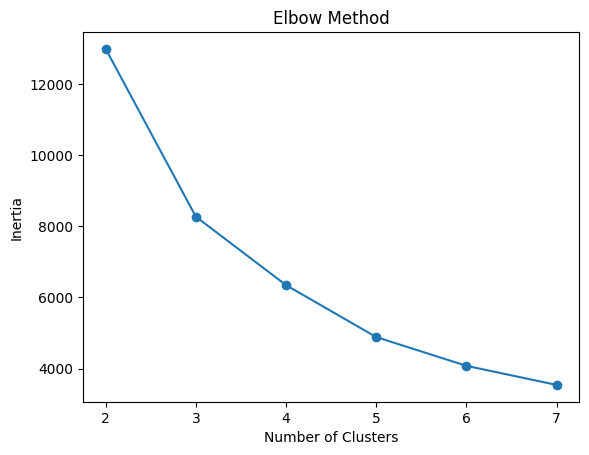

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [14]:
inertia

[12979.321189161092,
 8267.712629768148,
 6345.586391697241,
 4887.147342328282,
 4079.5428607953986,
 3543.4965598798544]

In [30]:
kmeans = KMeans(n_clusters=4, random_state=42)
df["segment"] = kmeans.fit_predict(X_scaled)

In [31]:
df.groupby("segment")[["tenure", "MonthlyCharges", "TotalCharges", "service_count"]].mean()

,tenure,MonthlyCharges,TotalCharges,service_count
segment,,,,
0,54.038306,30.101210,1615.461442,2.089718
1,59.327820,92.030125,5449.386441,6.733835
2,17.220506,78.877349,1336.666731,4.582154
3,9.208116,34.082899,270.339043,1.747246


In [32]:
pd.crosstab(df["segment"], df["Churn"], normalize="index") * 100

Churn,No,Yes
segment,,
0,95.564516,4.435484
1,85.012531,14.987469
2,55.898756,44.101244
3,71.130435,28.869565


In [33]:
df['segment'].value_counts().sort_index()

segment
0     992
1    1995
2    2331
3    1725
Name: count, dtype: int64